## Version 1---let's go

In [109]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [110]:
words = open('../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [111]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # split up dataset
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*X.shape[0])
    n2 = int(0.9*X.shape[0])
    Xtr, Xdev, Xte = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yte = Y.tensor_split((n1, n2), dim=0)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte 

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words, block_size)
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

#### Andrej's way of defining hyperparameters--n_emb is the number of embedding dimensions, and n_hidden is the "number of units" in the hidden layer, i.e. the number of neurons that are in the hidden layer

In [81]:
n_emb = 10 
n_hidden = 200

In [82]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [90]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    if i == 0:
        print(f'logits.shape: {logits.shape}')
        print(f'logits: {logits.sum(dim=1)}')
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

logits.shape: torch.Size([32, 27])
logits: tensor([145.5124, 115.1474, 102.7783,  70.1643, -61.4457, -47.5532, 139.2638,
        111.6086, -91.3452, 172.0565, -46.0027,  87.0198, 188.1665,  45.9197,
         85.6741, -21.7896, -91.3452, 124.6485,  60.7803, 165.3859, 111.3461,
        -91.3452, 159.5296, 146.9364, 179.8806, -24.8138, 111.4430, -47.5532,
         72.3310, -46.0027,  48.9861,  98.4889], grad_fn=<SumBackward1>)
loss at step 0: 1.8353


KeyboardInterrupt: 

In [ ]:
plt.plot(lossi)

In [45]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 2.0658719539642334
val 2.4074912071228027


##### Testing the model out

In [89]:
g = torch.Generator().manual_seed(2147483647+10)
block_size = 3 # this should be initialized earlier

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    
    while True:
        ## forward pass of the neural network 
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution to get the next character
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # shift context window and keep track of samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # if next sample is a '.', break out of loop, and move onto next word
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

eriah.
myah.
heel.
nah.
halarethrathagrace.
aderydoeliah.
myirealeigh.
catanassalyziah.
taa.
nyshahmrishiriel.
charrith.
joxginosaluya.
thdir.
yuhna.
ehs.
kayshastoyanahil.
calyahsyn.
zakol.
juren.
cry.


The current problem is that the loss originally starts very high at 27, and then comes way down. This is an indication that the model is not initialized properly. In practice, we'll have some idea of what the loss should be at initialization, and it definitely shouldn't be above like 10. This means that randomly initializing (our weights?) is not the thing to do, since technicially at initialization, we don't expect our characters to have any more probability of showing up at the very beginning. there's no context in the model, yet, which explains why the loss is so high at the beginning. 

This means that we need to reconfigure (our weights?) at initialization differently.

No, it's not the weights. We have to make sure that we're configuring the probabilities of each character to be uniform at the very beginning. This makes me think that the initial logits should be uniform, which will then be fed into the loss, which will then be propogated backward through the network

So first we can find what the negative log probability is so that we can get a baseline of what we'd expect the loss to be at the very beginning

In [93]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

The very high loss comes from the fact tha tour network is very confidently wrong

Here is a four dimensional example of what's happening: Below is an example where all of the logits are uniformly distributed:

In [101]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[0].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

And here is what happens when the logits are not uniformly distributed, much like what our makemore logits look like

In [104]:
logits = torch.tensor([3.0, -5.0, 2.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
probs, loss

(tensor([6.6509e-01, 2.2311e-04, 2.4467e-01, 9.0010e-02]),
 tensor([0.4078, 8.4078, 1.4078, 2.4078]))

And look how large our loss is!

In [106]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
logits, probs, loss

(tensor([-0.0422,  1.6090,  0.9168,  0.2673]),
 tensor([0.0982, 0.5118, 0.2562, 0.1338]),
 tensor([2.3209, 0.6697, 1.3619, 2.0114]))

## Now let's re-start the initialization and see exactly where this is going wrong

In [81]:
n_emb = 10 
n_hidden = 200

In [119]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [120]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    break # after the first iteration
    
#print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 23.5514


This loss obviously sucks. So let's pay attention to how the logits are calculated. The logits are calculated using b2 and W2. So, what we can do as a start is just set b2 -> b2 * 0, and then we can make the influence of W2 to be W2 -> W2 * 0.01

In [134]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [135]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.2952
loss at step 10000 of 200000: 2.1570
loss at step 20000 of 200000: 2.2580
loss at step 30000 of 200000: 1.8434
loss at step 40000 of 200000: 2.3845
loss at step 50000 of 200000: 2.2542
loss at step 60000 of 200000: 1.9307
loss at step 70000 of 200000: 1.9975
loss at step 80000 of 200000: 2.0630
loss at step 90000 of 200000: 2.3506
loss at step 100000 of 200000: 2.0776
loss at step 110000 of 200000: 2.2042
loss at step 120000 of 200000: 2.2960
loss at step 130000 of 200000: 2.0624
loss at step 140000 of 200000: 2.1785
loss at step 150000 of 200000: 2.2665
loss at step 160000 of 200000: 1.8034
loss at step 170000 of 200000: 2.1239
loss at step 180000 of 200000: 1.8393
loss at step 190000 of 200000: 1.9416
-----
final loss: 1.8680247665428311


Check it out now, our loss is really small at the beginning! Andrej says to not set the weights of the network to be 0 because ... 

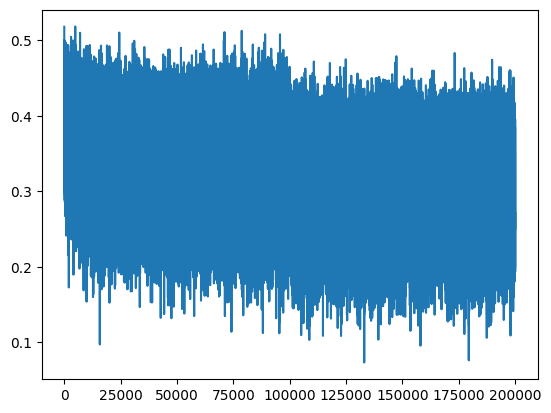

In [136]:
plt.plot(lossi)

Now we basically squashed the hockey stick part of the loss in order to get this kind of loss!

In [137]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 2.018929958343506
val 2.3594934940338135


Now the loss that we get is quite good!

Now there's another problem that's lurking in our code, and it has to do with what's going on with our h. Take a look:

In [138]:
h

tensor([[ 1.0000, -1.0000, -0.9979,  ..., -1.0000,  1.0000,  1.0000],
        [-1.0000,  0.6708, -0.8915,  ...,  0.1603,  1.0000,  1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9997, -0.9981, -0.9687],
        ...,
        [-0.9978, -1.0000, -1.0000,  ..., -1.0000,  0.9927,  0.9859],
        [-0.9988, -0.9678, -1.0000,  ...,  0.7620,  0.6630, -1.0000],
        [-0.9359, -1.0000, -1.0000,  ...,  0.9927, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

A lot of the values are either -1 or 1, and that's because tanh squashed all of our values into the range $[-1, 1]$. So we are missing out on aspects of the data because we (probably coarse grained) too much

In [141]:
h.shape

torch.Size([32, 200])

76.53125

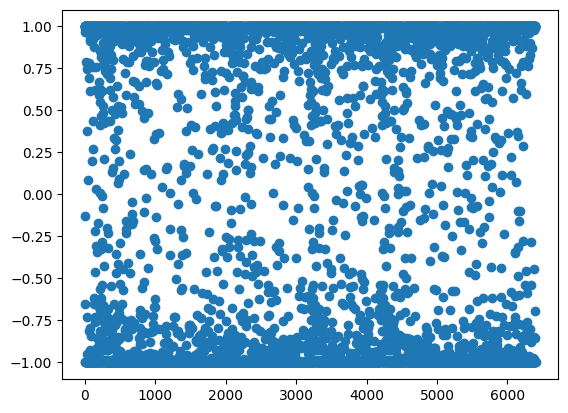

In [202]:
# using a context manager, let's understand how many values we're squashing and losing out on
with torch.no_grad():
    plt.scatter(torch.arange(h.nelement()), h.view(-1))
#count = ((h > 0.9) | (h < -0.9)).sum().item()
count = (h.abs() > 0.95).sum().item()
count / h.nelement() * 100

That's a lot of values that we're squashing!!!

Here's Andrej's way of understanding these values

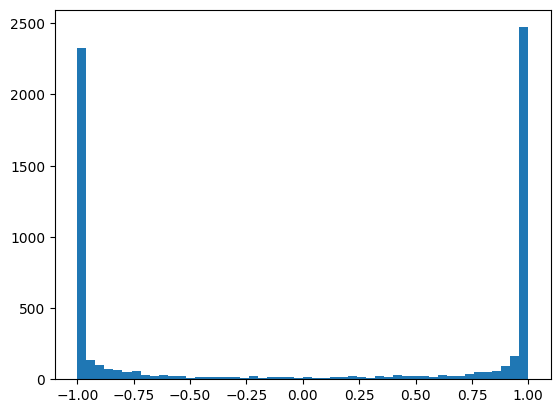

In [200]:
plt.hist(h.view(-1).tolist(), 50); # semi-colon prevents the output

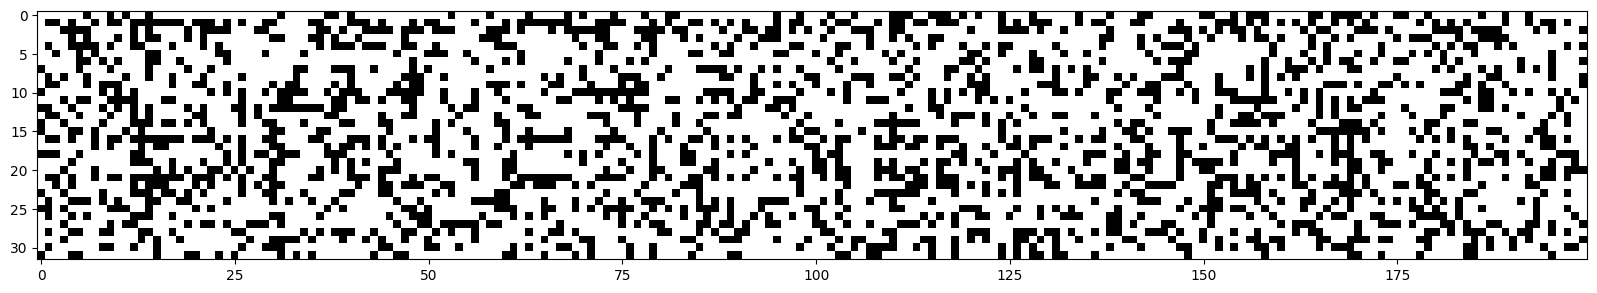

In [208]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # black == False

We can also look at the distribution of the pre-activations

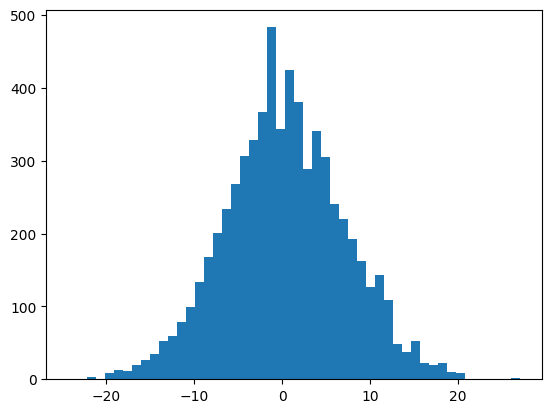

In [201]:
plt.hist(hpreact.view(-1).tolist(), 50); # semi-colon prevents the output

This effect basically happens because of the way the backpropogation words for tanh:

from micrograd:

self.grad += (1 - t**2) * out.grad 

this means that whenever our t = \pm 1, the gradient stops being calculated at that point, and the backpropogation doesn't go through. This is a huge problem

Now let's look at exactly where the back propogation would get killed

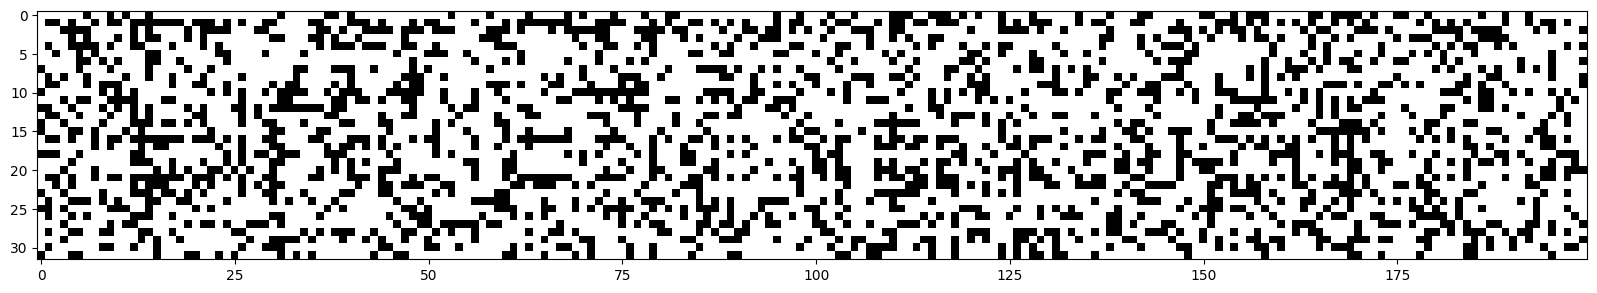

In [209]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # black == Not killed

This is pretty bad! This means that we have a lot of dead neurons in our network that aren't changing. In fact, there isn't even an entire row where there isn't a single kill

There are many activation functions where this is the case! ReLU, sigmoid, etc. The result is permanent brain damage. Any activation that has flat tails will end up having this problem

### Now let's restart the training process, but this time let's multiply b1 and W1 by very small numbers

In [210]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [211]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    break
    
#print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.3062


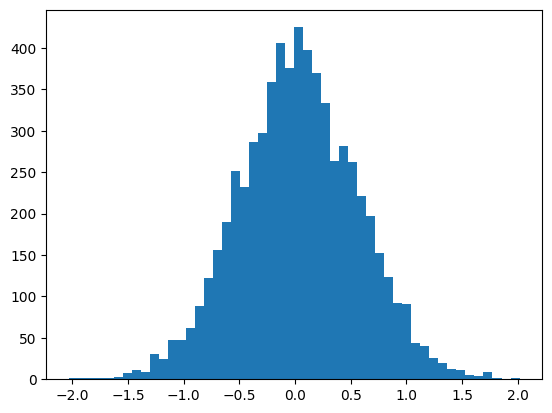

In [212]:
plt.hist(hpreact.view(-1).tolist(), 50); # semi-colon prevents the output

Now we're looking at a much smaller range of pre-activations!

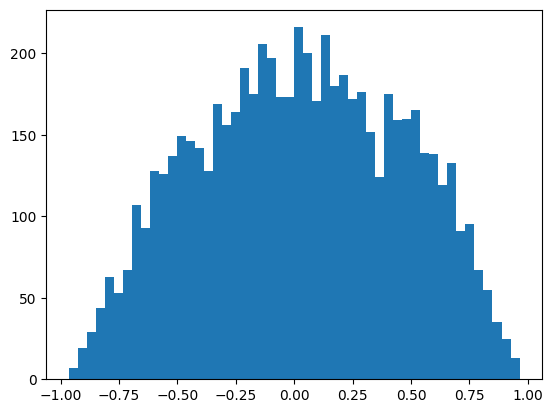

In [214]:
plt.hist(h.view(-1).tolist(), 50); # semi-colon prevents the output

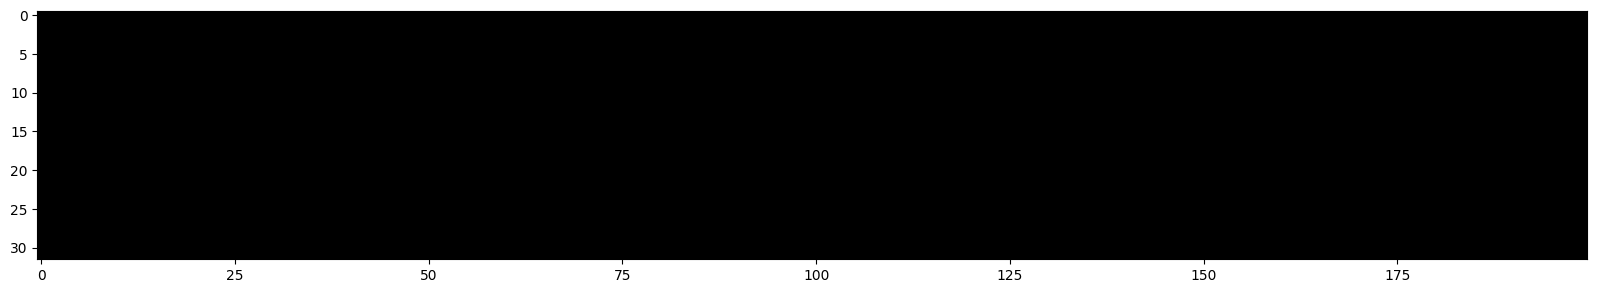

In [213]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # black == Not killed

And this gives us what we want --- basically no dead neurons!

### Let's increase the factor of W1 up to 0.2 and let's train our network

In [215]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [216]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
#print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.2840
loss at step 10000 of 200000: 2.3861
loss at step 20000 of 200000: 1.9076
loss at step 30000 of 200000: 2.3839
loss at step 40000 of 200000: 2.1266
loss at step 50000 of 200000: 2.1244
loss at step 60000 of 200000: 1.7104
loss at step 70000 of 200000: 1.6449
loss at step 80000 of 200000: 2.3467
loss at step 90000 of 200000: 1.9673
loss at step 100000 of 200000: 2.4707
loss at step 110000 of 200000: 1.8662
loss at step 120000 of 200000: 1.9769
loss at step 130000 of 200000: 1.8456
loss at step 140000 of 200000: 2.2282
loss at step 150000 of 200000: 2.0152
loss at step 160000 of 200000: 2.2836
loss at step 170000 of 200000: 1.6409
loss at step 180000 of 200000: 1.9572
loss at step 190000 of 200000: 1.8157


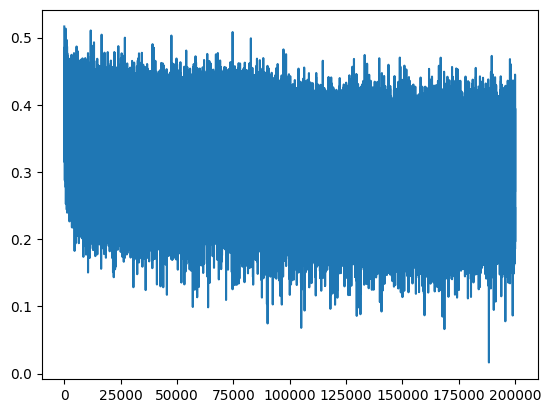

In [217]:
plt.plot(lossi)

In [219]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 1.987321138381958
val 2.3219101428985596


The validation loss is getting better! So now what's happening is with this one layer, these errors that we just debugged are forgiving, but we're just dealing with a one layer perceptron. If we're using a, say 50 layer MLP, then things will get more complicated and the errors will be harder to sus out

Now let's talk about where the "magic scaling numbers" of 0.2, 0.1, 0.01, came from, since there are very principled ways of understanding what these scaling numbers should be

We'll motivate the discussion by looking at tensor multiplications and analyzing the spread of these distributions

x.mean, x.std: -0.008074704557657242, 0.9981291890144348
w.mean, w.std: 0.0016323887975886464, 0.31949716806411743
y.mean, y.std: -0.0067728240974247456, 1.0091809034347534


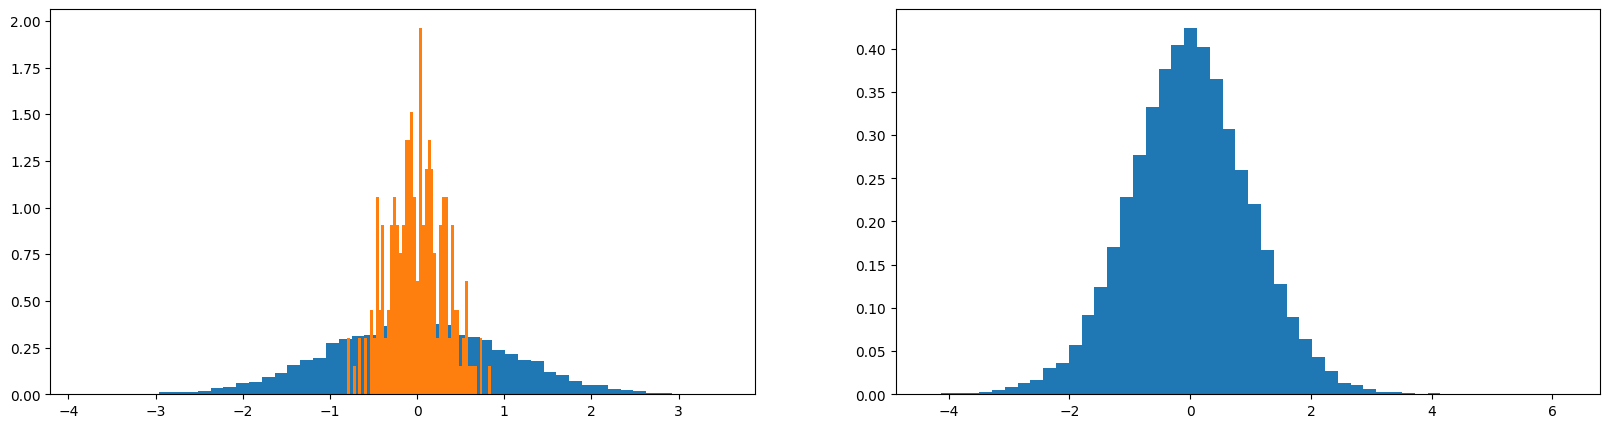

In [246]:
def plot_dists(x, w):
    print(f'x.mean, x.std: {x.mean()}, {x.std()}')
    print(f'w.mean, w.std: {w.mean()}, {w.std()}')
    
    y = x @ w
    print(f'y.mean, y.std: {y.mean()}, {y.std()}')
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].hist(x.view(-1).tolist(), 50, density=True)
    axs[0].hist(w.view(-1).tolist(), 50, density=True)
    axs[1].hist(y.view(-1).tolist(), 50, density=True)
    

_x = torch.randn(1000, 10)
#_w = torch.randn(10, 200)
_w = torch.randn(10, 20) / 10**0.5
plot_dists(_x, _w)

This happens because our weights are not initialized properly, so there is a rigorous way to set this, and we must normalize our weights by the square root of the first dimension (fan_in)

So what this means is that we need a type of 'gain' where we are multiplying our type of normalization by some factor, so that we can have some kind of factor that's working against our activation function (in our case, tanh): https://pytorch.org/docs/stable/nn.init.html

Whatver number that we multiplying our weights by, that becomes the standard deviation:

In [257]:
(torch.randn(100000)*0.2).std()

tensor(0.2007)

Using the above documentation, we find that the standard deviation of our weights should be:

In [247]:
(5/3) / 10**0.5

0.5270462766947299

For our actual example:

In [258]:
(5/3) / 30**0.5

0.3042903097250923

So now let's redo our weight initialization according to our desired spread of our weights:

In [260]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [261]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.3037
loss at step 10000 of 200000: 2.4304
loss at step 20000 of 200000: 2.3938
loss at step 30000 of 200000: 2.1395
loss at step 40000 of 200000: 2.2571
loss at step 50000 of 200000: 2.3195
loss at step 60000 of 200000: 2.2410
loss at step 70000 of 200000: 2.5520
loss at step 80000 of 200000: 1.9034
loss at step 90000 of 200000: 2.2490
loss at step 100000 of 200000: 2.0700
loss at step 110000 of 200000: 1.7735
loss at step 120000 of 200000: 2.0288
loss at step 130000 of 200000: 1.9278
loss at step 140000 of 200000: 2.0729
loss at step 150000 of 200000: 1.8185
loss at step 160000 of 200000: 1.8321
loss at step 170000 of 200000: 1.8281
loss at step 180000 of 200000: 2.3005
loss at step 190000 of 200000: 2.2106


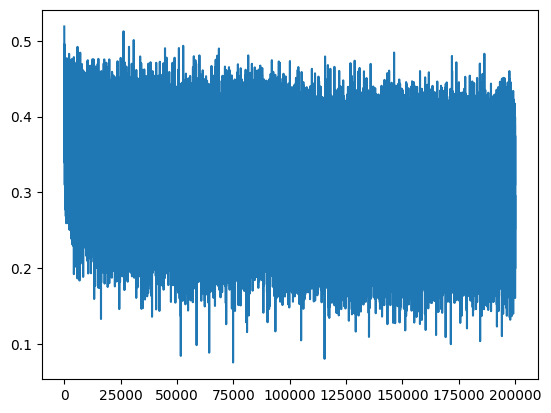

In [262]:
plt.plot(lossi)

In [268]:
split_loss('train')
split_loss('val')

train 2.0344274044036865
val 2.3536274433135986


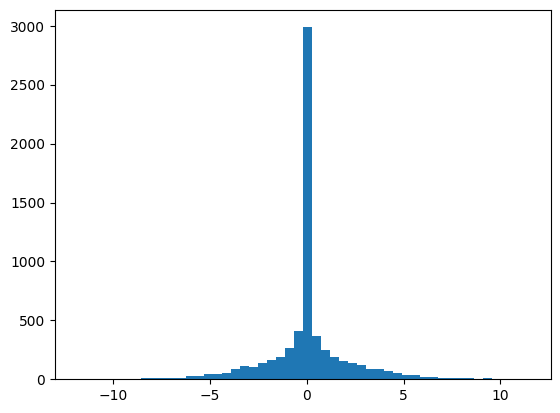

In [263]:
plt.hist(hpreact.view(-1).tolist(), 50); # semi-colon prevents the output

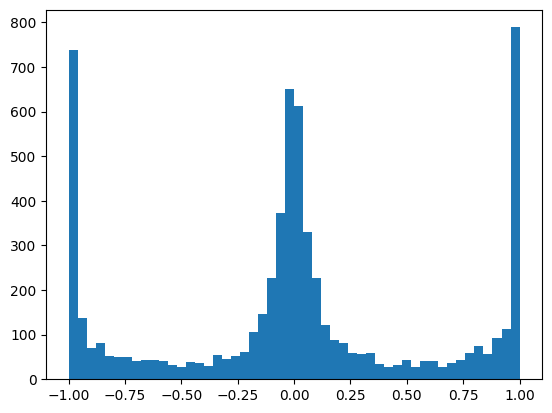

In [265]:
plt.hist(h.view(-1).tolist(), 50); # semi-colon prevents the output

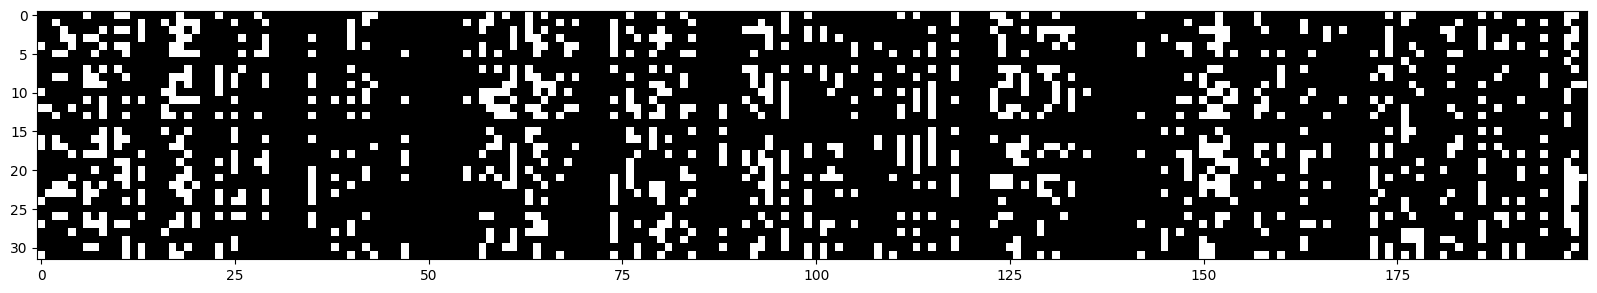

In [264]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # black == Not killed

So really nothing happened. However, there are some modern innovations that will allow us to just set the initial hidden layer states to be (unit gaussian?) with standard deviation being 1. This process is called batch normalization, and it just works. I realize that this should be an obvious thing to do, but it does seem weird since we're transforming these squashed tanh outputs and we're going to (port that into a Gaussian?) at the beginning of the standard deviation

creates unit Gaussian states

The point is that, depending on the pre-activations, when we tanh through the hidden layer--when we are activating these neurons--we could either be squashing our data, or if the values are too small or close to zero, these won't really activate the neurons

### First let's get the mean and std of the hpreact , and we'll further use this for to normalize all of the batches (where the name BatchNorm comes in)

In [284]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [287]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [288]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 11897


In [ ]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) 
    
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

The problem right now, though, is that no matter what our back propogation will do to our parameters, the pre-activations will always be scaled to a unit Gaussian, which gets rid of a lot of the dynamics of how these parameters will move around as the network is trained. 

This is addressed in the batch norm paper, where we'll be scaling these unit Gaussian pre-activations according to how the network will be trained

In [291]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 12297


In [292]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    hpreact = bngain *(hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.2990
loss at step 10000 of 200000: 2.3108
loss at step 20000 of 200000: 1.7275
loss at step 30000 of 200000: 2.2982
loss at step 40000 of 200000: 2.4409
loss at step 50000 of 200000: 1.8850
loss at step 60000 of 200000: 2.3002
loss at step 70000 of 200000: 2.3418
loss at step 80000 of 200000: 2.0484
loss at step 90000 of 200000: 2.3110
loss at step 100000 of 200000: 1.6579
loss at step 110000 of 200000: 1.6148
loss at step 120000 of 200000: 2.2140
loss at step 130000 of 200000: 2.0414
loss at step 140000 of 200000: 2.0088
loss at step 150000 of 200000: 2.2594
loss at step 160000 of 200000: 2.1024
loss at step 170000 of 200000: 2.1218
loss at step 180000 of 200000: 1.9911
loss at step 190000 of 200000: 2.2055
-----
final loss: 1.8018673701694772


In [293]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain *(hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 2.0192711353302
val 2.3262975215911865


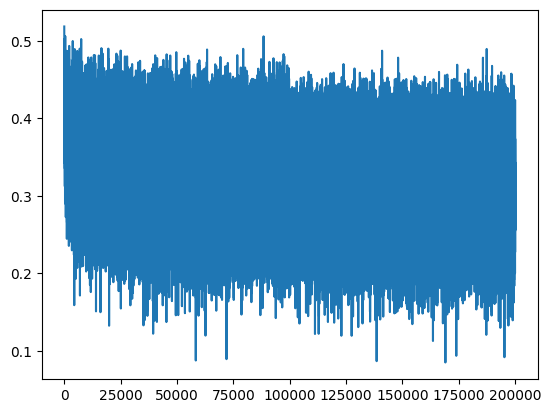

In [294]:
plt.plot(lossi)

#### As the MLP becomes deeper, it will become way more difficult to try to scale our weights so that the squashing doesn't affect much. So with BatchNorm, this allows for a nice way to normalize our batches throughout training

But here's the deal, though. Since we're using batch normalization, we are introducing couplings between layers of the network, since the batchnorm layer prior is dependent on another batchnorm. this introduces a 'jitter' effect because of these second order dependencies on prior batchnorms

This is because we are sampling the example distribution randomly, so when we're normalizing a batch, we are carrying all of the other examples with it within the normalization

On a more practical note, once we have a neural network trained, we want to be able to deploy it to a practical setting where we can feed in examples and infer how good of a loss we obtain

But the problem is that in the current code, the inference step which comes after the training is going to be expecting a batch, when we basically just want to understand the entire network

The solution to this is to just calculate the mean and std on the entire dataset, after we have done our training, and we'll use this for our batch normalization in the validation setting. An advantage of this is that we are taking the entire dataset into account when performing batchnorm for our validation setting, as opposed to looking at just a batch of our validation set. We do this by:

In [295]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 12297


In [296]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    hpreact = bngain *(hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 3.3169
loss at step 10000 of 200000: 1.9859
loss at step 20000 of 200000: 1.9923
loss at step 30000 of 200000: 2.2331
loss at step 40000 of 200000: 2.0246
loss at step 50000 of 200000: 1.9295
loss at step 60000 of 200000: 2.2896
loss at step 70000 of 200000: 2.2134
loss at step 80000 of 200000: 2.3598
loss at step 90000 of 200000: 1.7344
loss at step 100000 of 200000: 2.1518
loss at step 110000 of 200000: 1.7303
loss at step 120000 of 200000: 1.7550
loss at step 130000 of 200000: 1.7492
loss at step 140000 of 200000: 2.1324
loss at step 150000 of 200000: 1.8329
loss at step 160000 of 200000: 1.7798
loss at step 170000 of 200000: 1.7061
loss at step 180000 of 200000: 1.8832
loss at step 190000 of 200000: 2.1332
-----
final loss: 1.8711718738543246


Now we're going to calibrate the batch norm of the entire training set and obtain the mean and std specifically for our batchnorm

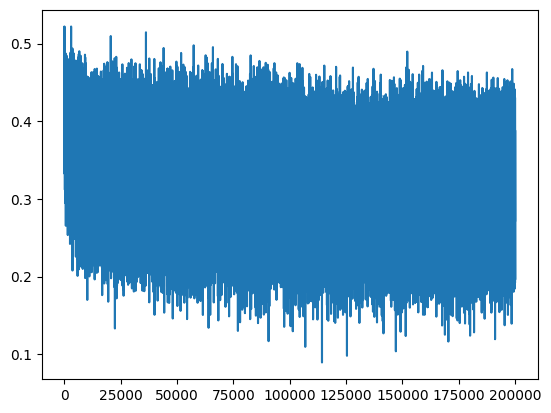

In [299]:
plt.plot(lossi);

In [302]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # get the mean and std of the entire training data set to use it for our examples
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

And now during our validation time, we are going to use these means and stds instead of looking at the batch of examples that we're looking to pass in

In [304]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 2.019453525543213
val 2.328335762023926


In practice, nobody does this, and instead we calculate the mean and stds during run time. We will keep track of these quantities throughout training in the following way:

In [315]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

total parameters: 12297


In [308]:
max_steps = 200_000
batch_size = 32
lossi = []
epsilon = 1e-5 # additional variable which 

for i in range(max_steps):
    
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batches for X, Y
    
    # forward pass
    emb = C[Xb] # embed all characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate all vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)    
    hpreact = bngain *(hpreact - bnmeani) / bnstdi + bnbias
    
    # since these aren't going to part of our graph, we don't want grads calculated to save memory
    # chosen this way to "smoothly" allow the running quantities to converge to what we'd
    # expect when we calculated everything post-training
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact) # hidden layer construction
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i} of {max_steps}: {loss:.4f}')
    lossi.append(loss.log10().item())
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

loss at step 0 of 200000: 2.5688
loss at step 10000 of 200000: 1.9954
loss at step 20000 of 200000: 2.3880
loss at step 30000 of 200000: 1.7471
loss at step 40000 of 200000: 1.9239
loss at step 50000 of 200000: 2.3104
loss at step 60000 of 200000: 2.1436
loss at step 70000 of 200000: 2.0606
loss at step 80000 of 200000: 2.2860
loss at step 90000 of 200000: 1.9895
loss at step 100000 of 200000: 1.9913
loss at step 110000 of 200000: 1.8458
loss at step 120000 of 200000: 1.8725
loss at step 130000 of 200000: 1.8096
loss at step 140000 of 200000: 2.4699
loss at step 150000 of 200000: 2.7640
loss at step 160000 of 200000: 2.1739
loss at step 170000 of 200000: 1.9031
loss at step 180000 of 200000: 2.1651
loss at step 190000 of 200000: 2.0818
-----
final loss: 1.7829159858122186


No, the goal is that the running mean and std will match what we'd get if we calculated these quantities on the training data post-training, which is more efficient

In [312]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # get the mean and std of the entire training data set to use it for our examples
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

#bnmean.shape, bnstd.shape
bnstd, bnstd_running

(tensor([[2.3800, 1.9625, 2.1629, 1.9860, 2.2097, 2.4488, 2.3892, 2.4931, 2.2125,
          2.0553, 2.3861, 2.2883, 2.0976, 2.1095, 2.1303, 2.6561, 2.3443, 2.0082,
          2.2172, 2.1770, 2.2368, 2.5123, 2.0573, 2.0258, 2.2999, 1.9383, 2.1029,
          2.5023, 2.3194, 2.4684, 1.5281, 2.2004, 2.2743, 2.1484, 2.2145, 2.0580,
          2.2768, 2.2962, 2.4988, 2.0697, 2.2700, 2.1524, 2.4902, 1.6727, 2.3491,
          2.2581, 2.1506, 2.5963, 2.1051, 2.4574, 2.1873, 2.0303, 2.1775, 1.9082,
          2.4701, 2.2989, 2.2542, 2.2004, 2.3561, 2.3317, 2.0594, 2.1983, 1.7352,
          2.1428, 2.0772, 2.2061, 2.1487, 2.5649, 2.0104, 2.2325, 2.2589, 2.1115,
          2.0865, 2.0025, 1.9774, 1.8928, 2.4383, 2.2251, 1.7313, 2.3707, 1.9934,
          1.7273, 2.0787, 2.4538, 2.2412, 2.2156, 2.1173, 2.4657, 2.3654, 2.8435,
          2.1155, 1.7822, 2.2114, 2.2255, 1.9866, 2.5966, 2.1835, 1.8789, 2.1484,
          2.2289, 2.1919, 2.2915, 2.2701, 2.1914, 1.7692, 2.2777, 1.9509, 2.2286,
          1.9697

In [313]:
@torch.no_grad() # this decorator disables all gradient tracking, saving memory by not book-keeping
def split_loss(split: str):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # you're indexing into this dict to get the correct specification
    
    # forward pass, with correctly specified data sets
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_emb)
    hpreact = embcat @ W1 + b1
    # now replace mean and std with running quantities that we get during training
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
# obtain loss with our weights without doing back propogation, much more efficient
split_loss('train')
split_loss('val')

train 2.017698287963867
val 2.323526620864868


Post this step, I added the epsilon step since this is how you make the behavior of the network well behaved when the std=0, and the b1's will also be subtracted away due to how the batchnorm works, so I commented and adjusted for this. the batchnorm acts as its own bias, so any additional bias containing constants in the layers before a batchnorm layer will have no affect